# Burrau  Experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Burrau">
             Initial value problem: Burrau</a></li>

<li><a href="#Ode-problem">
             Ode problem</a></li>
             
<li><a href="#DynamicalODEProblem">
             DynamicalODEProblem</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

<li><a href="#Work-Precision-diagrams">
             Work-Precision diagrams</a></li> 

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO

In [3]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [5]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem: Burrau

In [65]:
setprecision(BigFloat, 108);
include("../examples/Nbody.jl")
include("../examples/InitialBurrau.jl")

t0=0.0
t1=63.0
t1=10.0

u064,Gm64 =InitialBurrau(Float64)
lpp=Gm64
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=InitialBurrau(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128,;lpp=lpp)
(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64,3}, Array{Float64,1}, Tuple{Float64,Float64}, Array{BigFloat,3}, Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [20]:
setprecision(BigFloat, 256)
sol =solve(prob128,Vern9(),saveat=0.1, abstol=1e-24,reltol=1e-24);
@save "./Data/plei_test_solF128.jld2" sol

#@load "./Data/plei_test_solF128.jld2" sol
test_sol = TestSolution(sol)
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  184722
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          11545
Number of rejected steps:                          0

<a href="#top">Back to the top</a>

## Float64 Computations (DynamicalODEProblem)

In [66]:
q064=u064[2,:,:]
v064=u064[1,:,:]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);

### IRKGL16 

In [67]:
(sol1,iters1,steps1) = solve(probdyn64,IRKGL163(), reltol=1e-12, abstol=1e-12,adaptive=true,myoutputs=true, 
                                mixed_precision=false)
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  8307
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          163
Number of rejected steps:                          13

<a href="#top">Back to the top</a>

## Float128 Computations (OdeProblem)

In [23]:
setprecision(BigFloat, 108);

### IRKGL16 

In [68]:
(sol11,iters11,steps11) = solve(prob128,IRKGL16(), reltol=1e-12, abstol=1e-12, adaptive=true,myoutputs=true,
                             mixed_precision=false)
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  29526
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          163
Number of rejected steps:                          13

### IRKGL16 (Mixed-Precision)

In [69]:
(sol12,iters12,steps12) = solve(prob128,IRKGL16(),reltol=1e-12, abstol=1e-12,adaptive=true,myoutputs=true,
                              mixed_precision=true,low_prec_type=Float64)
sol12.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  8956
Number of function 2 evaluations:                  73596
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          163
Number of rejected steps:                          13

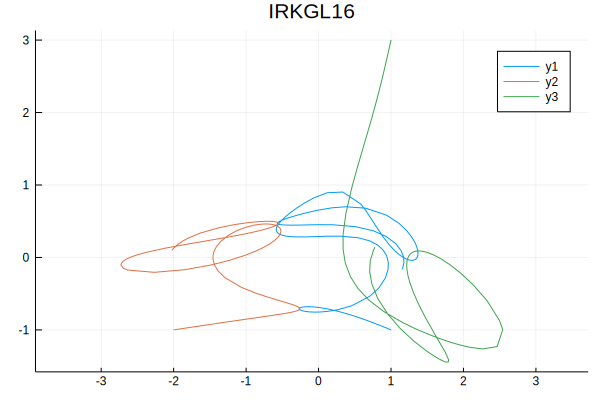

In [74]:
pl1 = plot(title="IRKGL16",aspect_ratio=1)

ulist11 = sol11.u[1:end]
tlist11 = sol11.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist11)     
 ylist  = map(u->u[2,2,j], ulist11)     
 pl1 = plot!(xlist,ylist) # label = bodylist[j])   
end  
plot(pl1)

<a href="#top">Back to the top</a>

## Float128 Computations (DynamicalODEProblem)

In [75]:
setprecision(BigFloat, 108);

In [80]:
q0128=u0128[2,:,:]
v0128=u0128[1,:,:]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);

In [86]:
a=sol11.u[2]
a[1,:,:]

3×3 Array{BigFloat,2}:
 -0.0102533   0.0144776   -0.00221469
  0.00432544  0.00221469  -0.010162  
  0.0         0.0          0.0       

In [87]:
b=sol21.u[2]
b[2,:,:]

3×3 Array{BigFloat,2}:
 -0.0102527   0.0144768   -0.00221458
  0.00432535  0.00221458  -0.0101617 
  0.0         0.0          0.0       

### IRKGL16 

In [81]:
(sol21,iters21,steps21) = solve(probdyn128,IRKGL163(), reltol=1e-12, abstol=1e-12,adaptive=true,myoutputs=true, 
                                mixed_precision=false)
sol21.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  16163
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          165
Number of rejected steps:                          13

<a href="#top">Back to the top</a>

## Error in energy

In [83]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialBurrau(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

ΔE = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol.u)./E0.-1
ΔE1 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol1.u)./E0.-1
ΔE11 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol11.u)./E0.-1
ΔE12 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol12.u)./E0.-1
ΔE21 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol21.u)./E0.-1;
#ΔE21 = map(x->NbodyEnergy(BigFloat.(vcat(x[2,:],x[1,:])),Gm128), sol21.u)./E0.-1
(Float32(maximum(abs.(ΔE))),Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE11))) ,Float32(maximum(abs.(ΔE12))),Float32(maximum(abs.(ΔE21))))

(2.8039654f-23, 7.02814f-5, 7.358741f-14, 7.358741f-14, 7.02814f-5)

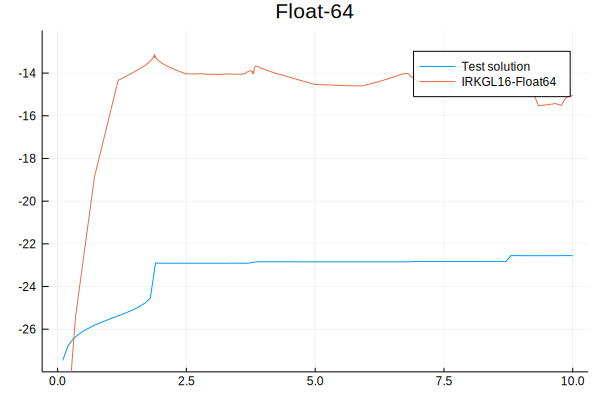

In [25]:
ylimit1=-28
ylimit2=-12
plot(sol.t,log10.(abs.(ΔE)), label="Test solution", title="Float-64",
    ylims=(ylimit1,ylimit2),)
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-Float64",
     ylims=(ylimit1,ylimit2),)

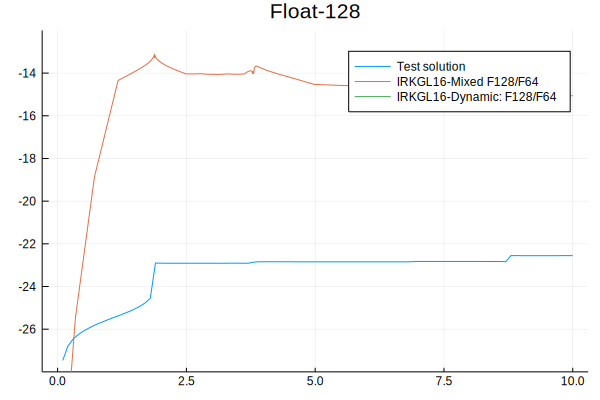

In [26]:
ylimit1=-28
ylimit2=-12
plot(sol.t,log10.(abs.(ΔE)), label="Test solution", title="Float-128",
    ylims=(ylimit1,ylimit2),)
plot!(sol12.t,log10.(abs.(ΔE12)), label="IRKGL16-Mixed F128/F64",
     ylims=(ylimit1,ylimit2),)
plot!(sol21.t,log10.(abs.(ΔE21)), label="IRKGL16-Dynamic: F128/F64",
     ylims=(ylimit1,ylimit2),)

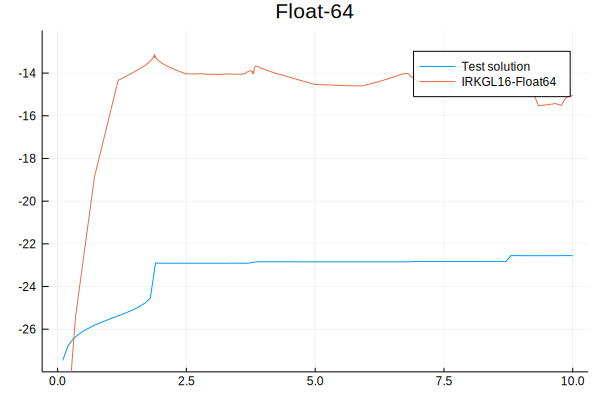

In [24]:
ylimit1=-28
ylimit2=-12
plot(sol.t,log10.(abs.(ΔE)), label="Test solution", title="Float-64",
    ylims=(ylimit1,ylimit2),)
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-Float64",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [14]:
Threads.nthreads()

1

In [56]:
abstols = 1.0 ./ 10.0 .^ (10:17)
reltols = 1.0 ./ 10.0 .^ (10:17);

### Float64 (DynamicalProblem)

In [57]:
q064=u064[1:14]
v064=u064[15:28]
probdyn64 = DynamicalODEProblem(dotq,dotv,q064,v064,tspan64);

In [75]:
setups = [
          Dict(:alg=>Vern9()),
          Dict(:alg=>IRKGL163())
]
wp2 = WorkPrecisionSet(probdyn64,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=10000000)
plot(wp2);

In [77]:
### Float128 (SecondOrderProblem)

In [62]:
using RecursiveArrayTools
q064=u064[1:14]
v064=u064[15:28]
prob2nd64 = SecondOrderODEProblem(f2nd!,v064,q064,tspan64);

In [63]:
ux=sol.u[end]
solx=ArrayPartition(ux[15:28],ux[1:14])
test_solx = TestSolution(tspan128,[solx]);

In [76]:
setups = [
          Dict(:alg=>DPRKN12())   
]
wp3 = WorkPrecisionSet(prob2nd64,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=1000000)
plot(wp3);

### Plot: OdeProblem+DynamicalProblem+SecondOrderProblem (Float64)

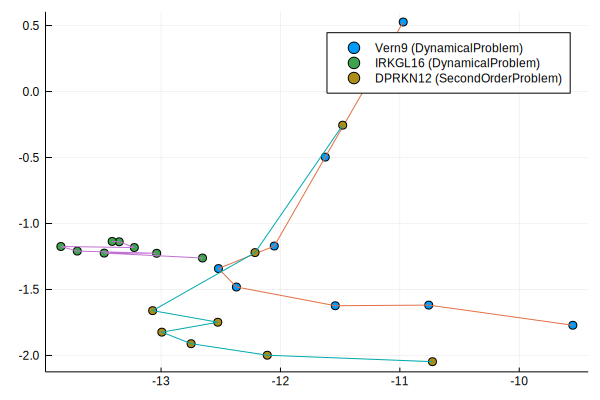

In [78]:
k=1
plot(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicalProblem)")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="")
# 
k=2
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="IRKGL16 (DynamicalProblem)")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="")
#
k=1
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), seriestype=:scatter, label="DPRKN12 (SecondOrderProblem)")
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), label="")

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [15]:
now()

2020-06-18T22:20:28.491

In [16]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:26)
reltols = 1.0 ./ 10.0 .^ (12:26);

### Float128 (OdeProblem)

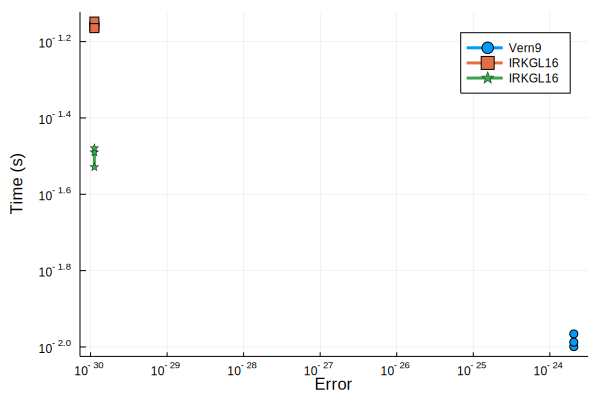

In [17]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>true,:low_prec_type=>Float64)
]
wp11 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=100000)
plot(wp11)

### Float128 (DynamicalProblem)

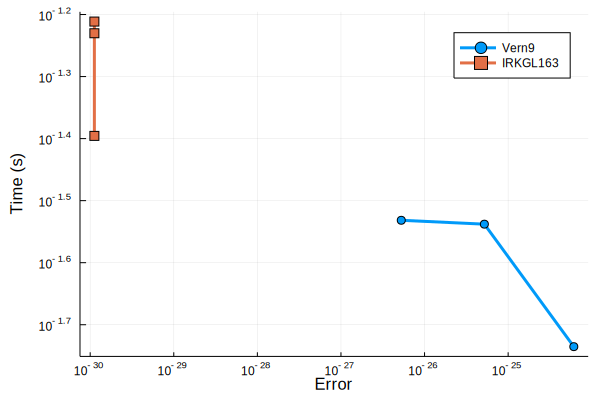

In [18]:
setups = [
          Dict(:alg=>Vern9()),
          Dict(:alg=>IRKGL163())
]
wp12 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=100000)
plot(wp12)

### Float128 (SecondOrderProblem)

In [19]:
using RecursiveArrayTools
q0128=u0128[1:14]
v0128=u0128[15:28]
prob2nd128 = SecondOrderODEProblem(f2nd!,v0128,q0128,tspan128);

In [20]:
ux=sol.u[end]
solx=ArrayPartition(ux[15:28],ux[1:14])
test_solx = TestSolution(tspan128,[solx]);

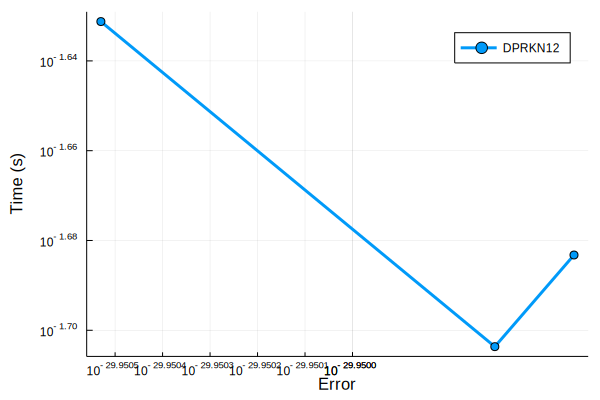

In [22]:
setups = [
          Dict(:alg=>DPRKN12())   
]
wp13 = WorkPrecisionSet(prob2nd128,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=100000)
plot(wp13)

### Plot: OdeProblem+DynamicalProblem+SecondOrderProblem

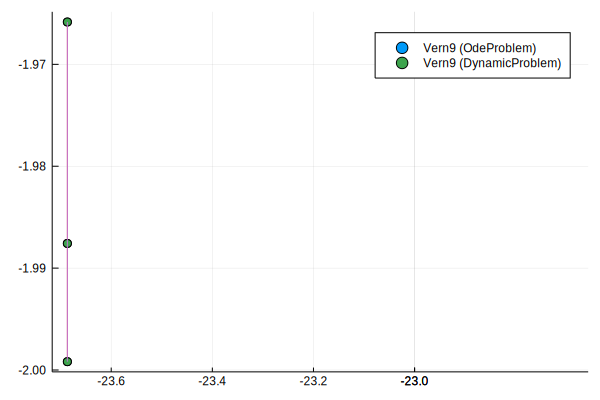

In [27]:
k=1
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="Vern9 (OdeProblem)")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="")
# 
k=1
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicProblem)")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="")


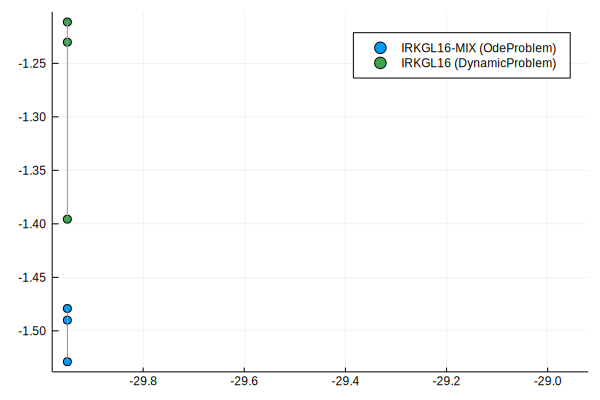

In [29]:
k=3
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX (OdeProblem)")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="")
# 
k=2
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="IRKGL16 (DynamicProblem)")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="")

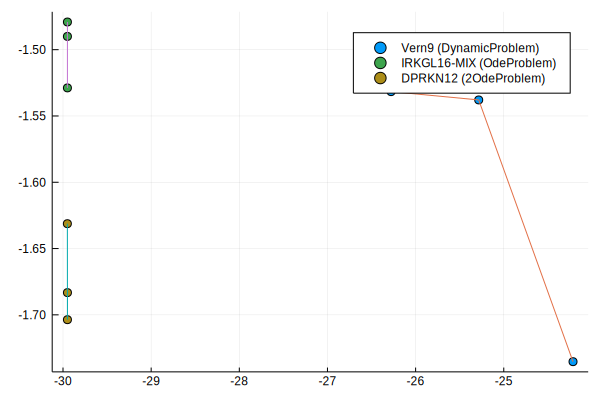

In [31]:
k=1
plot(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicProblem)")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="")
#
k=3
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX (OdeProblem)")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="")
#
k=1
plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), seriestype=:scatter, label="DPRKN12 (2OdeProblem)")
plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), label="")

<a href="#top">Back to the top</a>

In [26]:
now()

2020-06-18T22:23:06.376